In [283]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn # layer types
import torch.nn.functional as func 
import torch.optim as optim
import matplotlib.pyplot as plt

In [250]:
triumf_ml1_dir = '/home/s4hoque/DwaveSampInteg'
# path to semi-trained piplus model
#DwaveSampInteg/CaloQVAE/outputs/2022-11-30/16-39-46/synthetic_images_piplus.pt
#DwaveSampInteg/CaloQVAE/outputs/2022-12-01/22-29-17/synthetic_images_piplus.pt
pi_plus = triumf_ml1_dir+'/CaloQVAE/outputs/2022-12-01/22-29-17/synthetic_images_piplus.pt'

In [136]:
triumf_ml1_dir = '/home/s4hoque/DwaveSampInteg'
# path to semi-trained piplus model
#DwaveSampInteg/CaloQVAE/outputs/2022-11-30/18-02-26/synthetic_images_gamma.pt
gamma_plus = triumf_ml1_dir+'/CaloQVAE/outputs/2022-11-30/18-02-26/synthetic_images_gamma.pt'
piplus = triumf_ml1_dir+'/CaloQVAE/outputs/2022-11-30/18-02-26/synthetic_images_gamma.pt'

In [251]:
# path to eplus
# DwaveSampInteg/CaloQVAE/outputs/2022-11-30/22-26-46/synthetic_images_eplus.pt
triumf_ml1_dir = '/home/s4hoque/DwaveSampInteg'
gamma_plus = triumf_ml1_dir+'/CaloQVAE/outputs/2022-11-30/22-26-46/synthetic_images_eplus.pt'

In [252]:
piplus_data = torch.load(pi_plus)

In [253]:
gamma_data = torch.load(gamma_plus)

In [254]:
len(piplus_data) # 1024 different data

10

In [255]:
len(gamma_data)

10

In [256]:
piplus_tensor_orig = torch.cat(piplus_data)
piplus_tensor = piplus_tensor_orig/piplus_tensor_orig.size(1)  #torch.nn.functional.normalize(piplus_tensor_orig, dim=1)
piplus_tensor.size()  

torch.Size([10240, 504])

In [257]:
# inspect piplus tensor begin

In [258]:
piplus_tensor.size()

torch.Size([10240, 504])

In [259]:
torch.sum(piplus_tensor[0])

tensor(2.5075)

In [260]:
piplus_tensor

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0021, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0028, 0.0021, 0.0000]])

In [261]:
# inspect piplus tensor end

In [262]:
gamma_tensor_orig = torch.cat(gamma_data)
gamma_tensor = gamma_tensor_orig/gamma_tensor_orig.size(1)
gamma_tensor.size()  

torch.Size([10240, 504])

In [263]:
# eplus_tensor = piplus_tensor
# gamma_tensor = piplus_tensor
# gamma_tensor.size()

In [264]:
ONES = torch.ones(piplus_tensor.size(0)) # pp=1
ZEROS = torch.zeros(gamma_tensor.size(0)) # pp=0
piplus_labels = ZEROS
gamma_labels = ONES

In [320]:
all_data = torch.cat((piplus_tensor, gamma_tensor),dim=0)
all_labels = torch.cat((piplus_labels, gamma_labels), dim=0)
dataset = TensorDataset(all_data, all_labels)
data_loader = DataLoader(dataset, shuffle=False, batch_size=all_data.size(0))

In [321]:
print(all_data.size())

torch.Size([20480, 504])


In [322]:
# next(iter(data_loader))[0].size() # 20480 x 504 (all are legit the pixes values)
# next(iter(data_loader))[1].size() # 20480 (all 1 and 0)
inputs = next(iter(data_loader))[0]
targets = next(iter(data_loader))[1]
print(targets)
#targets = torch.unsqueeze(targets, 1)


tensor([0., 0., 0.,  ..., 1., 1., 1.])


In [323]:
class Net(nn.Module):
    """
    This class builds the neural network structure with 3 layers.
        Layer 1: num_features number of units
        layer 2: num_hiddden_units=100 hidden units seem to work well
        layer 3: num_classes=5 number of output classes
    """
    def __init__(self, num_features, num_hiddden_units, num_classes):
        super(Net, self).__init__() 
        self.fc1= nn.Linear(num_features, num_hiddden_units)
        self.fch1 = nn.Linear(num_hiddden_units, num_hiddden_units)
        self.fch2 = nn.Linear(num_hiddden_units, num_hiddden_units)
        self.fch3 = nn.Linear(num_hiddden_units, num_hiddden_units)
        self.fch4 = nn.Linear(num_hiddden_units, num_hiddden_units)
        self.fch5 = nn.Linear(num_hiddden_units, num_hiddden_units)
        self.fch6 = nn.Linear(num_hiddden_units, num_hiddden_units)
        self.fch7 = nn.Linear(num_hiddden_units, num_hiddden_units)
        self.fc2= nn.Linear(num_hiddden_units, num_classes) 
    
    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fch1(h1))
        h3 = torch.tanh(self.fch2(h2))
        h4 = torch.tanh(self.fch3(h3))
        h5 = torch.tanh(self.fch4(h4)) 
        h6 = torch.tanh(self.fch5(h5)) 
        h7 = func.dropout(self.fch6(h6),p=0.2)
        #h8 = torch.tanh(self.fch7(h7)) 
        y = torch.sigmoid(self.fc2(h7))
        return y

    def reset(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [325]:
num_epochs=1000
display_epochs=200

In [327]:
model = Net(num_features=504, num_hiddden_units=200, num_classes=1)
optimizer = optim.SGD(model.parameters(), lr=3.5)
loss = torch.nn.L1Loss(reduction= 'mean')
obj_vals= []  
for epoch in range(num_epochs):   
    model_output = model.forward(inputs).reshape(-1)
    pred = (model_output>0.5).float()
    diff_tensor =  pred - targets 
    diff_tensor = torch.abs(diff_tensor)
    accuracy = 1-torch.sum(diff_tensor)/pred.size(0)
    #print(torch.sum(torch.abs(diff_tensor)))
    
#     print("model out is ", model_output)
#     print("bool out is ", out)
    #print("model out: {0} and size {1}".format(model_output,torch.sum(model_output)))
    obj_val = loss(model_output, targets)
    #test_obj_val = loss(model.forward(test_inputs), test_targets)
    optimizer.zero_grad() 
    obj_val.backward() 
    optimizer.step() 
    obj_vals.append(obj_val.item())
    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\tTrain Loss :{:.4f}\t accuracy :{:.4f}%'.format(epoch+1, num_epochs, obj_val.item(), accuracy*100))
print("\nTraining Completed")

Epoch [200/1000]	Train Loss :0.5000	 accuracy :50.0000%
Epoch [400/1000]	Train Loss :0.5000	 accuracy :50.0000%
Epoch [600/1000]	Train Loss :0.5000	 accuracy :50.0000%


KeyboardInterrupt: 

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch

In [ ]:
pp_acc = 0
for i in range(gamma_tensor.size(0)):
    if model.forward(gamma_tensor[i]) > 0.5: # piplus = 1, gamma=0
        pp_acc = pp_acc + model.forward(gamma_tensor)[i]
pp_acc/piplus_tensor.size(0)

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch

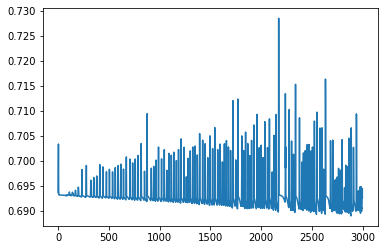

In [220]:
plt.plot(range(num_epochs), obj_vals)

In [ ]:
"""
ESSESNTIALLY IF U THINK of only the classical approach, we do BGS EACH TIME WE CALL GENERATE SAMPLES DWAVE TO GENERATE NEW IMAGES. BUT THIS IS NOT REALLY REQUIRED. 
WE CAN DO BGS ONLY ONCE AS THE NUMBER OF SAMPLES ARE NOT CHANGING ... MAYBE THE RAND () IN PRIOR DIASTRIBUTION ENSURES WE GET DIFFERENT SAMPLES ...MUST ASK ABHI !!!!

THIS EMPHASIZES THE NEED OF load_dwave and NEW_SAMPLES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
"""